# Two Atom Analysis Notebook

### Imports

In [1]:
%matplotlib inline
import numpy
from astropy.io import fits
numpy.set_printoptions(threshold=numpy.nan)
import matplotlib as plt
from matplotlib.pyplot import figure, hist, plot, title, xlabel, ylabel, subplots, errorbar
from matplotlib.cm import get_cmap
from dataAnalysisFunctions import (normalizeData, binData, guessGaussianPeaks, doubleGaussian, fitDoubleGaussian, 
                                   calculateAtomThreshold, getAnalyzedTunnelingData);
import sympy

### Experiment Parameters

In [2]:
# Constants
date = "160521";
fileName = "test";
runNumber = 57;
well1Position = 4;
well2Position = 6;
accumulations = 150;
### Zero-indexed!!!
# Horizontal
atom1Location = [1,well1Position - 1];
atom2Location = [1,well2Position - 1];
# Vertical
# atomLocation = [wellIndicator-1, 1];
picturesPerExperiment = 2;

### Constants

In [3]:
repositoryLocation = "\\\\andor\\share\\Data and documents\\Data repository\\";
fitsFileLocation = repositoryLocation + date + "\\data_" + str(runNumber) + ".fits";
keyFileLocation = repositoryLocation + date + "\\key_" + str(runNumber) + ".txt";

### Load Key

In [4]:
#
key = numpy.array([]);
with open(keyFileLocation) as keyFile:
    for line in keyFile:
        key = numpy.append(key, float(line.strip('\n')))

### Load Fits File

In [5]:
# Get the array from the fits file. That's all I care about.
fitsInfo = (fits.open(fitsFileLocation, "append"));
fitsInfo.info();
rawData = fitsInfo[0].data;
# the .shape member of an array gives an array of the dimesnions of the array.
numberOfPictures = rawData.shape[0];
numberOfExperiments = int(numberOfPictures / picturesPerExperiment)
horizontalImageDimension = rawData.shape[1];
verticalImageDimension = rawData.shape[2];

Filename: \\andor\share\Data and documents\Data repository\160521\data_57.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       9   (9, 3, 2400)   int32   


### Initial Data Analysis

In [6]:
#
allAtomData = [0,0];
firstExperimentData = [0,0];
allAtomData[0], firstExperimentData[0] = normalizeData(picturesPerExperiment, rawData, atom1Location);
allAtomData[1], firstExperimentData[1] = normalizeData(picturesPerExperiment, rawData, atom2Location);

### First Shot Histogram

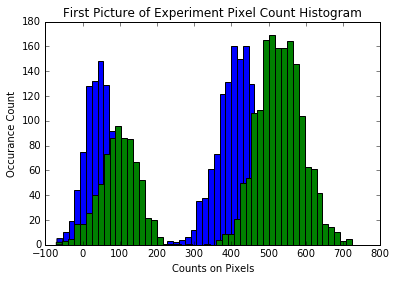

In [7]:
# Plot histogram 
figure(1)
hist(allAtomData[0], 50);
title("First Picture of Experiment Pixel Count Histogram");
ylabel("Occurance Count");
xlabel("Counts on Pixels");
hist(allAtomData[1], 50);


### Get Binned Data

In [8]:
binCenters = [0,0];
binnedData = [0,0];
binCenters[0], binnedData[0] = binData(5, allAtomData[0]);
binCenters[1], binnedData[1] = binData(5, allAtomData[1]);

### Get Peak Guesses

In [9]:
guessLocation1 = [0,0]
guessLocation2 = [0,0]
guessLocation1[0], guessLocation2[0] = guessGaussianPeaks(allAtomData[0], binCenters[0], binnedData[0]);
guessLocation1[1], guessLocation2[1] = guessGaussianPeaks(allAtomData[0], binCenters[1], binnedData[1]);
print(guessLocation1)
print(guessLocation2)

[406.25, 514.5]
[46.25, 99.5]


### Get Thresholds

In [10]:
guess = [0,0];
gaussianFitVals = [0,0];
thresholds = [0,0];
thresholdFidelity = [0,0];
guess[0] = numpy.array([100, guessLocation1[0], 30, 200, guessLocation2[0], 10]);
guess[1] = numpy.array([100, guessLocation1[1], 30, 200, guessLocation2[1], 10]);
gaussianFitVals[0] = fitDoubleGaussian(binCenters[0], binnedData[0], guess[0]);
gaussianFitVals[1] = fitDoubleGaussian(binCenters[1], binnedData[1], guess[1]);
thresholds[0], thresholdFidelity[0] = calculateAtomThreshold(gaussianFitVals[0]);
thresholds[1], thresholdFidelity[1] = calculateAtomThreshold(gaussianFitVals[1]);

### Plot stuff

Thresholds Found: 187.247513548, 294.479643715
Threshold Fidelities: 99.9958960377%, 99.9944745898%
Loading Efficiencies: 71.5%, 78.16666666666666%


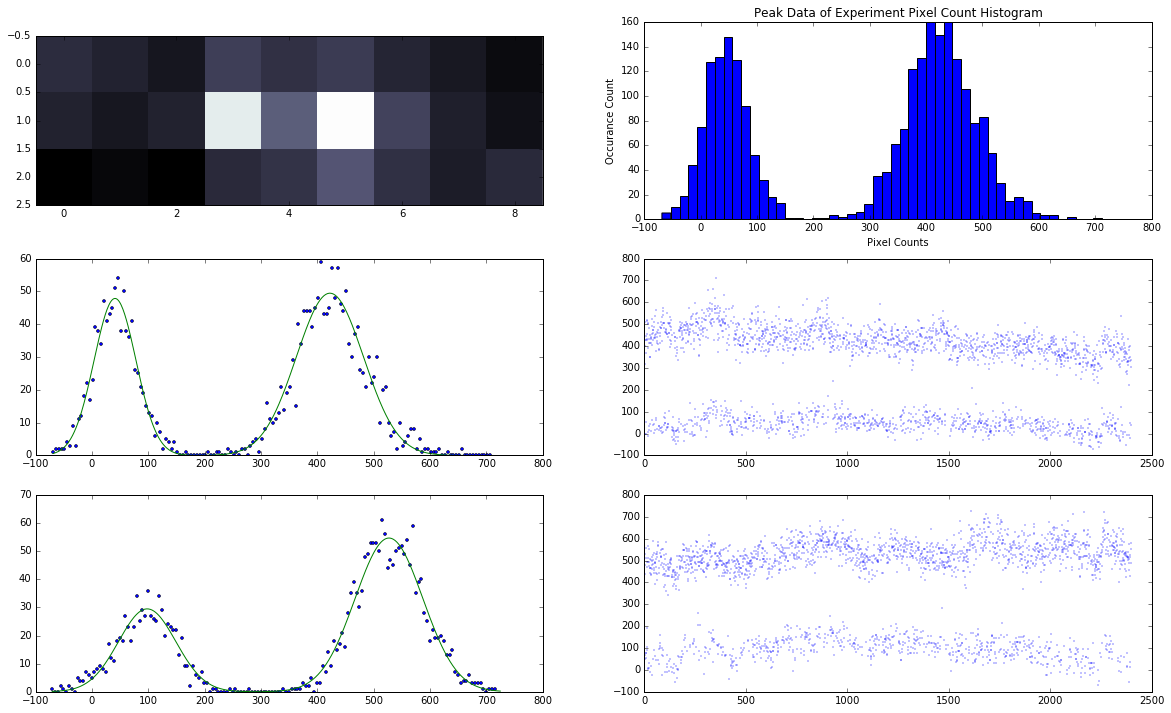

In [11]:
# make an image
figure, ((plot11, plot12), (plot21, plot22), (plot31, plot32)) = subplots(3, 2, figsize = (20,12))
plot11.imshow(rawData[100], interpolation='none', cmap = get_cmap("bone"));
# make a histogram
plot12.hist(allAtomData[0], 50);
plot12.set_title("Peak Data of Experiment Pixel Count Histogram");
plot12.set_ylabel("Occurance Count");
plot12.set_xlabel("Pixel Counts");
# plot the fit on top of the histogram
plot21.plot(binCenters[0], binnedData[0], "o", markersize = 3);
fineXData = numpy.linspace(min(allAtomData[0]), max(allAtomData[0]),500);
plot21.plot(fineXData, doubleGaussian(fineXData, *gaussianFitVals[0]))
plot22.plot(allAtomData[0], ".", markersize = 1);

plot31.plot(binCenters[1], binnedData[1], "o", markersize = 3);
fineXData = numpy.linspace(min(allAtomData[1]),max(allAtomData[1]),500);
plot31.plot(fineXData, doubleGaussian(fineXData,*gaussianFitVals[1]))

plot32.plot(allAtomData[1], ".", markersize = 1);

print("Thresholds Found: " + str(thresholds[0]) + ", " + str(thresholds[1]));
print("Threshold Fidelities: " + str(thresholdFidelity[0] * 100) + "%, " + str(thresholdFidelity[1] * 100) + "%")
atomCount = [0, 0];
for experimentInc in range(0, firstExperimentData[0].size):
    if firstExperimentData[0][experimentInc] > thresholds[0]:
        atomCount[0] += 1;
    if firstExperimentData[1][experimentInc] > thresholds[1]:
        atomCount[1] += 1;
print("Loading Efficiencies: " + str(atomCount[0] / firstExperimentData[0].size * 100) + "%, " +
      str(atomCount[1] / firstExperimentData[1].size * 100) + "%")

### Analyze Data

[ 0.12666667  0.16        0.15333333  0.14666667  0.16        0.16666667
  0.14666667  0.15333333]


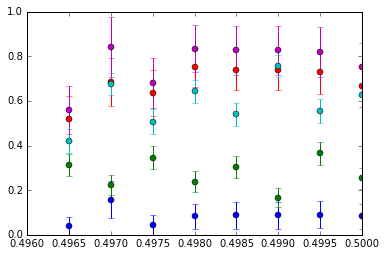

In [12]:
firstToFirst, firstToSecond, bothToBoth, bothToOne, loadingProbabilityArray, summedData \
            = getAnalyzedTunnelingData(allAtomData, thresholds, key, accumulations, numberOfExperiments);
print(loadingProbabilityArray)
# Plot survival data.
plt.pylab.figure(1)
plt.pylab.ylim([0,1]);
errorbar(firstToFirst[:,0], firstToFirst[:,1], yerr=firstToFirst[:,2], linestyle = "none", color = "r", fmt = "o");
errorbar(firstToSecond[:,0], firstToSecond[:,1], yerr=firstToSecond[:,2], linestyle = "none", color = "b", fmt = "o");
errorbar(bothToBoth[:,0], bothToBoth[:,1], yerr=bothToBoth[:,2], linestyle = "none", color = "c", fmt = "o");
errorbar(bothToOne[:,0], bothToOne[:,1], yerr=bothToOne[:,2], linestyle = "none", color = "g", fmt = "o");
errorbar(summedData[:,0],summedData[:,1], yerr = summedData[:,2], linestyle = "none", color = "m", fmt = "o");


### Export Data

In [13]:
# Export data exactly how it used to be exported using mathematica, so that a mathematica file can read it. 
fitsInfo.close()
#collatedData = {accumulations, peakData, key, toPlot, captProbs, dataRaw, toPlot2, toPlotBoth, toPlotBoth11, 
    #Date[]};
outputName = (repositoryLocation + date + "\\" + fileName + "_run" + str(runNumber) + "_pair"
              + str(well1Position) + str(well2Position) + ".tsv");
print(outputName)
with open(outputName, "w") as record_file:
    # accumulations is special since it's an integer.
    record_file.write(str(accumulations) + "\n");
    ### Version for mathematica compatibility
    # Peak Data
    for peakInc in range(0, allAtomData[0].size):
        record_file.write(str(allAtomData[0][peakInc]) + "\t");
    record_file.write("\n");
    # key
    for keyInc in range(0, key.size-1):
        record_file.write(str(key[keyInc]) + "\t");
    record_file.write(str(key[key.size-1]));
    record_file.write("\n");
    # firstToFirst
    firstToFirstDimensions = firstToFirst.shape;
    for firstToFirstPoints in range(0, firstToFirstDimensions[0]-1):
        record_file.write(str("{{"));
        record_file.write(str(firstToFirst[firstToFirstPoints][0]) + ", ");
        record_file.write(str(firstToFirst[firstToFirstPoints][1]) + "}, ");
        record_file.write("ErrorBar[" + str(firstToFirst[firstToFirstPoints][2]) + "]");
        record_file.write(str("}\t"));
    record_file.write(str("{{"));
    record_file.write(str(firstToFirst[firstToFirstPoints-1][0]) + ", ");
    record_file.write(str(firstToFirst[firstToFirstPoints-1][1]) + "}, ");
    record_file.write("ErrorBar[" + str(firstToFirst[firstToFirstPoints-1][2]) + "]");
    record_file.write(str("}"));
    record_file.write("\n")
        # capture probabilities data
    print(loadingProbabilityArray.size)
    for captureInc in range(0, loadingProbabilityArray.size):
        record_file.write(str(loadingProbabilityArray[captureInc]) + " ");
    record_file.write("\n");
    # raw data
    rawDataDimensions = rawData.shape;
    for pictureInc in range(0, rawDataDimensions[0]):
        record_file.write("{");
        for rowInc in range(0, rawDataDimensions[1]):
            record_file.write("{");
            for columnInc in range(0, rawDataDimensions[2]):
                record_file.write(str(rawData[pictureInc][rowInc][columnInc]) + " ")
            record_file.write("} ")
        record_file.write("}");
    record_file.write("\n");
    # firstToSecond
    firstToSecondDimensions = firstToSecond.shape;
    for firstToSecondPoints in range(0, firstToSecondDimensions[0]-1):
        record_file.write(str("{{"));
        record_file.write(str(firstToSecond[firstToSecondPoints][0]) + ", ");
        record_file.write(str(firstToSecond[firstToSecondPoints][1]) + "}, ");
        record_file.write("ErrorBar[" + str(firstToSecond[firstToSecondPoints][2]) + "]");
        record_file.write(str("}\t"));
    record_file.write(str("{{"));
    record_file.write(str(firstToSecond[firstToSecondPoints-1][0]) + ", ");
    record_file.write(str(firstToSecond[firstToSecondPoints-1][1]) + "}, ");
    record_file.write("ErrorBar[" + str(firstToSecond[firstToSecondPoints-1][2]) + "]");
    record_file.write(str("}"));
    record_file.write("\n")
    # bothToBoth
    bothToBothDimensions = bothToBoth.shape;
    for bothToBothPoints in range(0, bothToBothDimensions[0]-1):
        record_file.write(str("{{"));
        record_file.write(str(bothToBoth[bothToBothPoints][0]) + ", ");
        record_file.write(str(bothToBoth[bothToBothPoints][1]) + "}, ");
        record_file.write("ErrorBar[" + str(bothToBoth[bothToBothPoints][2]) + "]");
        record_file.write(str("}\t"));
    record_file.write(str("{{"));
    record_file.write(str(bothToBoth[bothToBothPoints-1][0]) + ", ");
    record_file.write(str(bothToBoth[bothToBothPoints-1][1]) + "}, ");
    record_file.write("ErrorBar[" + str(bothToBoth[bothToBothPoints-1][2]) + "]");
    record_file.write(str("}"));
    record_file.write("\n")
    # bothToOne
    bothToOneDimensions = bothToOne.shape;
    for bothToOnePoints in range(0, bothToOneDimensions[0]-1):
        record_file.write(str("{{"));
        record_file.write(str(bothToOne[bothToOnePoints][0]) + ", ");
        record_file.write(str(bothToOne[bothToOnePoints][1]) + "}, ");
        record_file.write("ErrorBar[" + str(bothToOne[bothToOnePoints][2]) + "]");
        record_file.write(str("}\t"));
    record_file.write(str("{{"));
    record_file.write(str(bothToOne[bothToOnePoints-1][0]) + ", ");
    record_file.write(str(bothToOne[bothToOnePoints-1][1]) + "}, ");
    record_file.write("ErrorBar[" + str(bothToOne[bothToOnePoints-1][2]) + "]");
    record_file.write(str("}"));
    record_file.write("\n")
    
    # sensible version
    # for dataInc in range(1,len(collatedData)):
        #record_file.write(str(collatedData[dataInc][0:len(collatedData[dataInc])]) + "\n");

\\andor\share\Data and documents\Data repository\160521\test_run57_pair46.tsv
8
